Motivation: Portfolio stress testing is a fundamental tool for assesing the resilience of equity portfolios under adverse market conditions. Unlike traditional risk measures, stress testing evaluates potencial losses arising from extreme but plausible scenarios, such a market crashes, volatility spikes, or systemic shocks.

## Portfolio Strees Testing

In [50]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

### Data Collection

In [51]:
# Selected Assets
tickers = ["IBM", "LLY", "MDGL", "GLD"]

# Time Period
start_date = "2007-01-01"
end_date = dt.datetime.today().strftime('%Y-%m-%d')


In [52]:
stocks = []
data = pd.DataFrame()

for stock in tickers:
    data = yf.download(stock, start=start_date, end=end_date, auto_adjust=True)
    data.columns = data.columns.droplevel(1)
    data['Ticker'] = stock
    stocks.append(data)

assets = pd.concat(stocks)
assets = assets.reset_index()   # ← convierte el índice en columna
assets.rename(columns={'Date': 'Date'}, inplace=True)
assets.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Ticker
0,2007-01-03,50.857731,51.448549,50.329651,50.810673,9619853,IBM
1,2007-01-04,51.401482,51.652447,50.653801,50.847257,11008627,IBM
2,2007-01-05,50.936142,51.213252,50.669488,51.030253,7553480,IBM
3,2007-01-08,51.709976,52.023688,51.422409,51.500836,10815640,IBM
4,2007-01-09,52.321712,52.457658,51.798865,51.804093,11619177,IBM


In [53]:
# Delete Unnecessary Columns
assets.drop(columns=["High", "Low", "Open"], inplace=True)

#### Return Calculation

In [54]:
assets["Return"] = assets.groupby("Ticker")["Close"].pct_change()
assets.head()

Price,Date,Close,Volume,Ticker,Return
0,2007-01-03,50.857731,9619853,IBM,NaN
1,2007-01-04,51.401482,11008627,IBM,0.010692
2,2007-01-05,50.936142,7553480,IBM,-0.009053
3,2007-01-08,51.709976,10815640,IBM,0.015192
4,2007-01-09,52.321712,11619177,IBM,0.011830


In [55]:
assets_matrix = assets.pivot(index="Date", columns="Ticker", values="Return")
assets_matrix.head()


Ticker,GLD,IBM,LLY,MDGL
Date,,,,
2007-01-03,NaN,NaN,NaN,NaN
2007-01-04,-0.010116,0.010692,0.002105,NaN
2007-01-05,-0.024007,-0.009053,-0.006112,NaN
2007-01-08,0.005152,0.015192,-0.004612,NaN
2007-01-09,0.006118,0.011830,0.000579,NaN


##### Individual Analysis

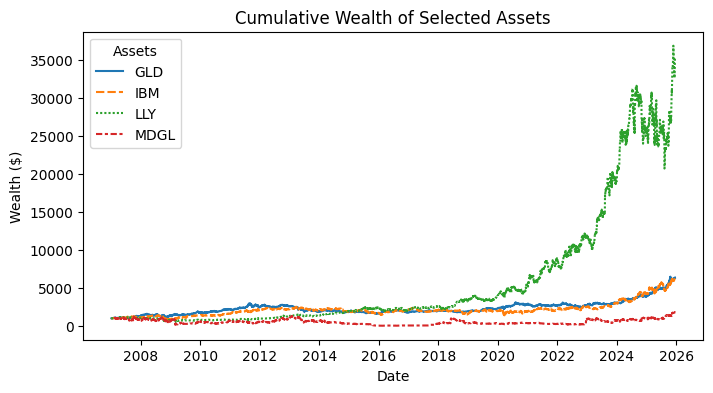

In [56]:
# Graphic of Wealth Evolution
wealth_assets = 1000 * (1 + assets_matrix).cumprod()

plt.figure(figsize=(8, 4))
sns.lineplot(data=wealth_assets)

plt.title("Cumulative Wealth of Selected Assets")
plt.xlabel("Date")
plt.ylabel("Wealth ($)")
plt.legend(title="Assets")

plt.show()

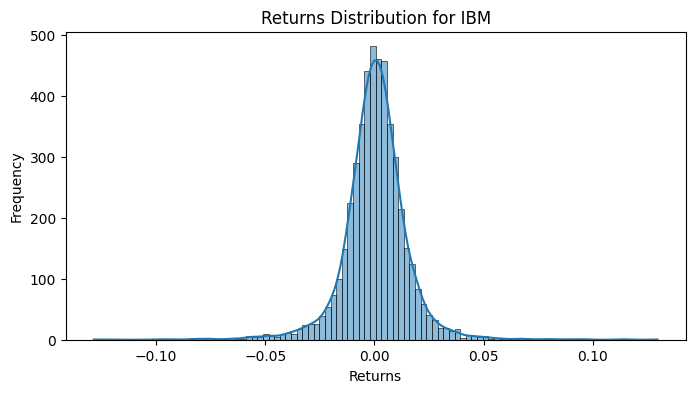

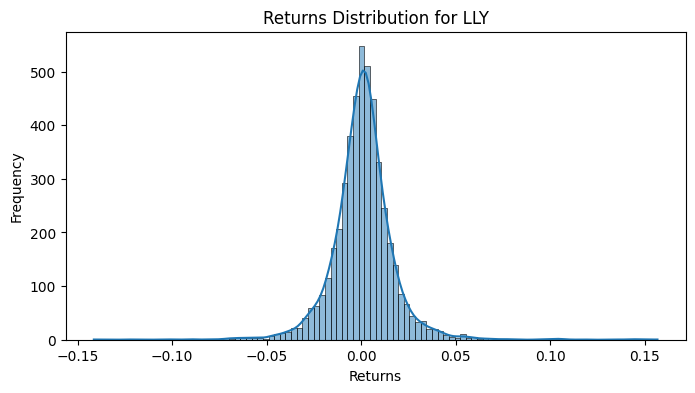

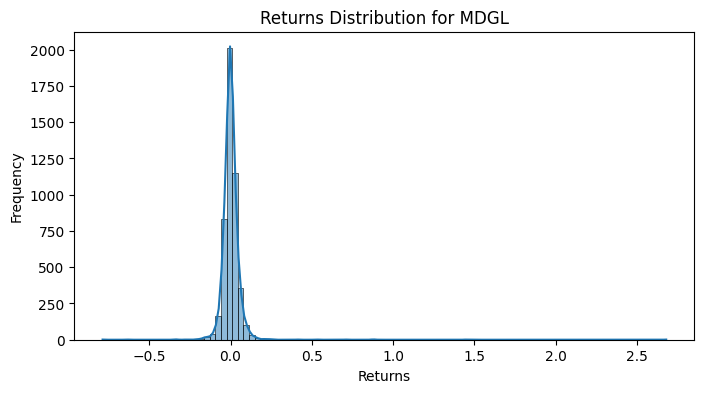

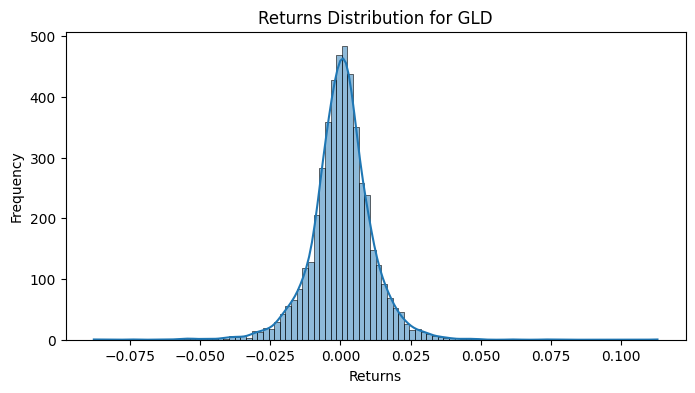

In [57]:
# Graphic of Returns Distribution
def plot_returns(col):
    plt.figure(figsize=(8, 4))
    sns.histplot(data=assets_matrix, x=col, bins=100, kde=True)

    plt.title(f'Returns Distribution for {col}')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    
    plt.show()

for ticker in tickers:
    plot_returns(ticker)


In [58]:
# Calculate VaR and CVaR using Historical Method
VaR = assets_matrix.quantile(0.05)
CVaR = assets_matrix[assets_matrix.le(VaR)].mean()

print("Value at Risk (VaR) at 5%:")
print((VaR * 100).map("{:.2f}%".format).to_string())

print("\nConditional Value at Risk (CVaR) at 5%:")
print((CVaR * 100).map("{:.2f}%".format).to_string())

Value at Risk (VaR) at 5%:
Ticker
GLD     -1.73%
IBM     -2.13%
LLY     -2.42%
MDGL    -5.91%

Conditional Value at Risk (CVaR) at 5%:
Ticker
GLD     -2.57%
IBM     -3.61%
LLY     -3.77%
MDGL    -9.72%


In [59]:
# Calculate VaR and CVaR Parametric Method
mean_returns = assets_matrix.mean()
std_returns = assets_matrix.std()
z_score = -1.645  # for 5% VaR

VaR_parametric = mean_returns + z_score * std_returns
CVaR_parametric = mean_returns - (std_returns * np.exp(-z_score**2 / 2) / (0.05 * np.sqrt(2 * np.pi)))
print("\nParametric Value at Risk (VaR) at 5%:")
print((VaR_parametric * 100).map("{:.2f}%".format).to_string())
print("\nParametric Conditional Value at Risk (CVaR) at 5%:")
print((CVaR_parametric * 100).map("{:.2f}%".format).to_string())


Parametric Value at Risk (VaR) at 5%:
Ticker
GLD      -1.77%
IBM      -2.42%
LLY      -2.70%
MDGL    -10.77%

Parametric Conditional Value at Risk (CVaR) at 5%:
Ticker
GLD      -2.23%
IBM      -3.05%
LLY      -3.41%
MDGL    -13.54%


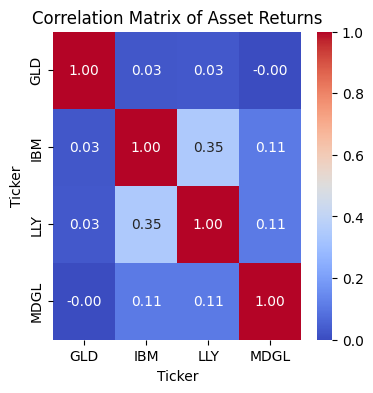

In [60]:
# Graphic of the correlation matrix
plt.figure(figsize=(4, 4))
sns.heatmap(assets_matrix.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Matrix of Asset Returns")

plt.show()

#### Portfolio Allocation

In [61]:
weights = np.array([0.25, 0.25, 0.25, 0.25])  # Equal weights for simplicity

portfolio_returns = pd.DataFrame(index=assets_matrix.index, columns=["Portfolio Return"])
portfolio_returns["Portfolio Return"] = assets_matrix @ weights
portfolio_returns.head()

,Portfolio Return
Date,
2007-01-03,NaN
2007-01-04,NaN
2007-01-05,NaN
2007-01-08,NaN
2007-01-09,NaN


In [62]:
rf = 0.03  # Risk-free rate

# Portfolio Return and Standard Deviation
annual_return = portfolio_returns["Portfolio Return"].mean() * 252  # Annualized return
annual_sd = portfolio_returns["Portfolio Return"].std() * np.sqrt(252)  # Annualized standard deviation
ratio_sharpe = (annual_return - rf) / annual_sd

print(f"Portfolio Annual Return: {annual_return*100:.2f}%")
print(f"Portfolio Standard Deviation: {annual_sd*100:.2f}%")
print(f"Ratio Sharpe: {ratio_sharpe:.2f}")

Portfolio Annual Return: 22.86%
Portfolio Standard Deviation: 30.01%
Ratio Sharpe: 0.66


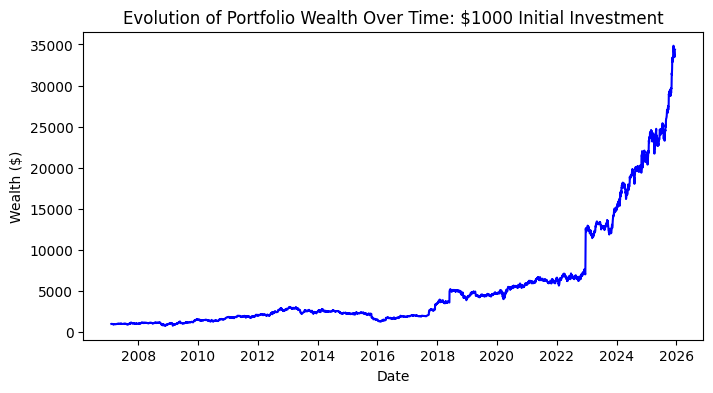

In [63]:
# Evolution of Wealth over Time
portfolio_returns["cumulative_returns"] = 1000 * (1 + portfolio_returns["Portfolio Return"]).cumprod()

plt.figure(figsize=(8, 4))
sns.lineplot(data=portfolio_returns, x=portfolio_returns.index, y="cumulative_returns", color="blue")

plt.title("Evolution of Portfolio Wealth Over Time: $1000 Initial Investment")
plt.xlabel("Date")
plt.ylabel("Wealth ($)")

plt.show()

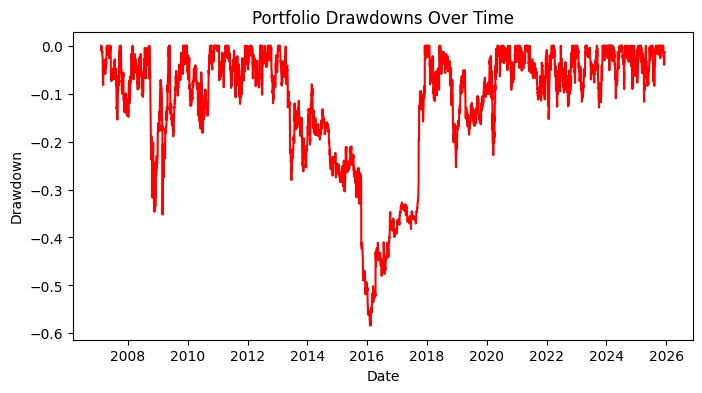

In [64]:
# Drawdown Calculation
portfolio_returns["previous_peaks"] = portfolio_returns["cumulative_returns"].cummax()
portfolio_returns["drawdowns"] = (portfolio_returns["cumulative_returns"] - portfolio_returns["previous_peaks"]) / portfolio_returns["previous_peaks"]

# Plot Drawdowns
plt.figure(figsize=(8, 4))
plt.plot(portfolio_returns["drawdowns"], color='red')

plt.title("Portfolio Drawdowns Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")

plt.show()

In [65]:
# MaxDrawdown across Historical Crisis
print("Max Drawdown during 2008 Financial Crisis:")
period_2008 = portfolio_returns.loc["2007-10-01":"2009-03-01"]
max_drawdown_2008 = period_2008["drawdowns"].min() * 100
print(f"Max Drawdown 2008: {max_drawdown_2008:.2f}%")

print("Max Drawdown during COVID-19 Pandemic:")
period_covid = portfolio_returns.loc["2020-02-01":"2020-06-01"]
max_drawdown_covid = period_covid["drawdowns"].min() * 100
print(f"Max Drawdown COVID-19: {max_drawdown_covid:.2f}%")

Max Drawdown during 2008 Financial Crisis:
Max Drawdown 2008: -35.24%
Max Drawdown during COVID-19 Pandemic:
Max Drawdown COVID-19: -22.83%


Monte Carlo Risk Analysis

In [66]:
# Risk Metrics for the Portfolio
mu = assets_matrix.mean().values
cov = assets_matrix.cov().values

In [67]:
# Simulate Portfolio Returns
n_simulations = 10000
simulated_assets_returns = np.random.multivariate_normal(mean=mu, cov=cov, size=n_simulations)
simulated_portfolio_returns = simulated_assets_returns.dot(weights)

# VaR and CVaR for Simulated Portfolio Returns
VaR_simulated = np.percentile(simulated_portfolio_returns, 5)
CVaR_simulated = simulated_portfolio_returns[simulated_portfolio_returns <= VaR_simulated].mean()
print(f"Simulated Portfolio VaR at 5%: {VaR_simulated*100:.2f}%")
print(f"Simulated Portfolio CVaR at 5%: {CVaR_simulated*100:.2f}%")

Simulated Portfolio VaR at 5%: -2.98%
Simulated Portfolio CVaR at 5%: -3.80%


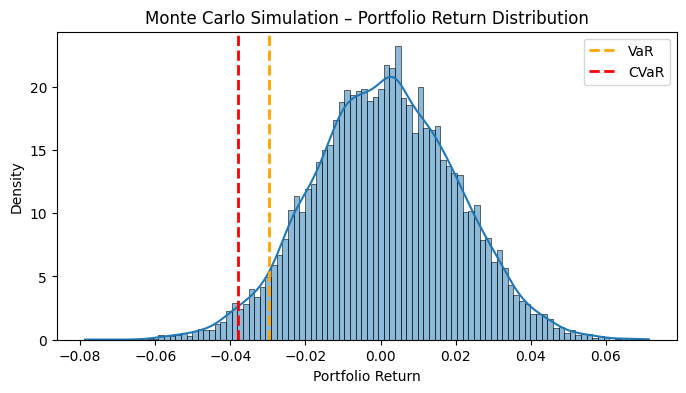

In [68]:
plt.figure(figsize=(8, 4))

sns.histplot(simulated_portfolio_returns, bins=100, kde=True, stat="density")

plt.axvline(VaR_simulated, linestyle='--', linewidth=2, label='VaR', color='orange')
plt.axvline(CVaR_simulated, linestyle='--', linewidth=2, label='CVaR', color='red')

plt.title('Monte Carlo Simulation – Portfolio Return Distribution')
plt.xlabel('Portfolio Return')
plt.ylabel('Density')
plt.legend()
plt.show()


#### Risk Contribution

In [69]:
# Marginal Risk Contribution
marginal_risk_contribution = cov.dot(weights) / np.sqrt(weights.T.dot(cov).dot(weights))

print("Marginal Risk Contribution per Asset:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {marginal_risk_contribution[i]*100:.2f}%")

Marginal Risk Contribution per Asset:
IBM: 0.17%
LLY: 0.56%
MDGL: 0.66%
GLD: 6.16%


In [70]:
RIC = 0.25 * marginal_risk_contribution
print("Risk Contribution per Asset:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {RIC[i]*100:.2f}%")

Risk Contribution per Asset:
IBM: 0.04%
LLY: 0.14%
MDGL: 0.17%
GLD: 1.54%


In [71]:
# Proof of Concept
volatility = RIC.sum() * np.sqrt(252) * 100
print(f"Portfolio Volatility from Risk Contributions: {volatility:.2f}%")

Portfolio Volatility from Risk Contributions: 30.00%
